In [1]:
import matplotlib.pyplot as plt
import torch

from flow_policy.cubic import CubicHermiteInterpolation
from flow_policy.traj import Trajectory, JoinTrajectories


In [2]:
def demonstration_traj_right() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = Trajectory(x=torch.zeros(25), t=torch.linspace(0, 0.25, 25))
    piece_2 = CubicHermiteInterpolation(
        Trajectory(
            x=torch.tensor([0.00, 0.62, 0.75, 0.5]),
            t=torch.tensor([0.25, 0.50, 0.75, 1.0])
        ),
        initial_slope=0.0,
        final_slope=-1,
    ).MakeTrajectory(torch.linspace(0.25, 1, 75))
    return JoinTrajectories(piece_1, piece_2)

def demonstration_traj_left() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = Trajectory(x=torch.zeros(25), t=torch.linspace(0, 0.25, 25))
    piece_2 = CubicHermiteInterpolation(
        Trajectory(
            x=torch.tensor([0.00, -0.62, -0.75, -0.5]),
            t=torch.tensor([0.25,  0.50,  0.75,  1.0])
        ),
        initial_slope=0.0,
        final_slope=1,
    ).MakeTrajectory(torch.linspace(0.25, 1, 75))
    return JoinTrajectories(piece_1, piece_2)

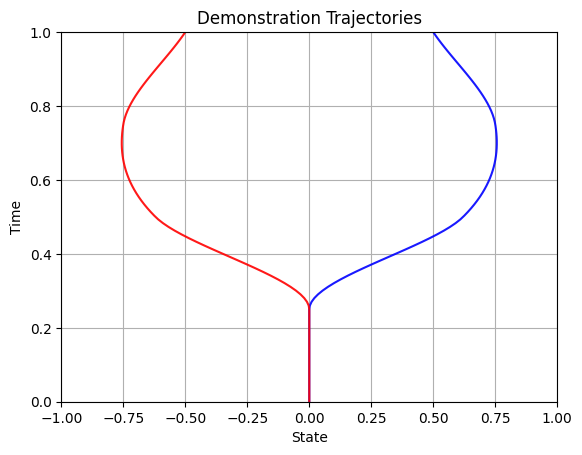

In [3]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()
plt.plot(traj_right.x, traj_right.t, color='blue', alpha=0.9)
plt.plot(traj_left.x, traj_left.t, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('State')
plt.ylabel('Time')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()